In [ ]:
#https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2

In [4]:
#imports
import os
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse
from spektral.data.graph import Graph
from keras.models import Model
from keras.layers import Dense, Dropout, Concatenate, Reshape, Add, BatchNormalization, Activation, Conv2D, Conv1D, Input, Flatten, MaxPooling1D, Lambda
from spektral.layers import APPNPConv, AGNNConv, ChebConv, GlobalAvgPool,GlobalSumPool,SAGPool,JustBalancePool,LaPool,SRCPool, GCNConv, GlobalSumPool, CensNetConv, GATConv, DiffusionConv, ARMAConv, GlobalAvgPool, GINConvBatch, GCSConv, GlobalMaxPool, EdgeConv, ECCConv, CrystalConv, GeneralConv,GINConv
from spektral.data import BatchLoader, DisjointLoader, Dataset
from spektral.transforms import GCNFilter, NormalizeAdj
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow import keras
import keras_tuner as kt
from keras import regularizers
import pickle 
import visualkeras
import keras.backend as K
from spektral.utils.convolution import chebyshev_filter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


In [18]:
features = pd.read_csv('thingi10k_data.csv', index_col=0)
print(features['build_time'].head())

def log_transform(x):
    return np.log(x + 1)

def inv_log_transform(x):
    return np.exp(x) - 1 
logtransformer = FunctionTransformer(func=log_transform, inverse_func=inv_log_transform, check_inverse=False)
pipe = Pipeline(steps=[ ('logtransformer', logtransformer)])

features["build_time"] = pipe.fit_transform(features["build_time"])

0    435
1     30
2     28
3     29
4    766
Name: build_time, dtype: int64


In [3]:
features = pd.read_csv('thingi10k_data.csv', index_col=0)
adjpath = '../Data/stl/adjacency_stl_simplified/'
cloudpath = '../Data/stl/nodefeatures_stl_simplified/'
edgepath = '../Data/stl/edgefeaturesmatrix_stl_simplified/'

coords = np.empty((1,3))
targets = np.empty(1)
print(coords.shape)

for i in range(3000):
    if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
        point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
        coords = np.concatenate((coords,point_cloud))
        targets = np.append(targets,features["build_time"][i])

        
coords = np.delete(coords,0,0)
coords.shape

(1, 3)


(3000000, 3)

In [4]:
centroid = np.mean(targets)
targets -= centroid
stddev = np.max(np.sqrt(np.sum(targets**2,axis=-1) / 2999))
stddev

830.2939568107494

In [6]:
def inverse_scale(value):
    return value * stddev + centroid

In [5]:
centroids = np.mean(coords,0)
centroids

array([76.85162636, 30.12397029, 19.48363157])

In [6]:
coordscentered = coords - centroids

[634.25992634  40.63999939  90.41378741]
[656.71110233  40.63999939 210.84211475]
[557.40829998  10.5160291   70.93015584]
[579.85947597  10.5160291  191.35848318]


In [7]:
furthest_distance = np.max(np.sqrt(np.sum(coordscentered**2,axis=-1) / 2999))
furthest_distance

142.0717318904484

In [19]:
coordscentered /= furthest_distance
coordscentered[0]

array([4.37512496, 0.05801626, 0.86090288])

In [8]:
#load data
#features = pd.read_csv('thingi10k_data.csv', index_col=0)

adjpath = '../Data/stl/adjacency_stl_simplified/'
cloudpath = '../Data/stl/nodefeatures_stl_simplified/'
edgepath = '../Data/stl/edgefeaturesmatrix_stl_simplified/'


class MyDataset(Dataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def read(self):
        output = []
        for i in range(3000):
            if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
                adjmatrix = scipy.sparse.load_npz(adjpath + f'{features["model_name"][i]}.npz')
                point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
                edgefeat = scipy.sparse.load_npz(edgepath + f'{features["model_name"][i]}.npz')
                output.append(
                    Graph(x=((point_cloud - centroids)/furthest_distance), a=edgefeat, y=features["build_time"][i])
                )

        return output

with tf.device("CPU"):
    dataset = MyDataset()

dataset

MyDataset(n_graphs=3000)

In [9]:
#Testdata
#features = pd.read_csv('thingi10k_data.csv', index_col=0)

class TestDataset(Dataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def read(self):
        output = []

        #files = os.listdir("../Data/adjmatrices/")
        for i in range(3000,3600):
            if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
                
                adjmatrix = scipy.sparse.load_npz(adjpath + f'{features["model_name"][i]}.npz')
                point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
                edgefeat = scipy.sparse.load_npz(edgepath + f'{features["model_name"][i]}.npz')
                #edgefeat = np.load(edgepath + f'{features["model_name"][i]}.npy').reshape(-1,1)
                output.append(
                    Graph(x=((point_cloud - centroids)/furthest_distance), a=edgefeat, y=features["build_time"][i])
                )

        return output
    
with tf.device("CPU"):
    testdataset = TestDataset()
    
testdataset

KeyboardInterrupt: 

In [63]:
#Preprocessing: choose filter based on Conv layer
dataset.apply(GCNFilter())
testdataset.apply(GCNFilter())

In [9]:
dataset.apply(NormalizeAdj())
testdataset.apply(NormalizeAdj())

In [9]:
#Model 1
xi = Input(shape=(None,3), name= "inputx")
ai = Input(shape=(None,None), name= 'inputa')
x1 = GCNConv(64, 'relu')([xi,ai])
x2 = GCNConv(64, 'relu')([x1,ai])
x3 = GCNConv(64, 'relu')([x2,ai])
x4 = GCNConv(128, 'relu')([x3,ai])
x = Concatenate()([x1,x2,x3,x4])
x = GlobalMaxPool()(x)
x = Dense(432, 'relu')(x)   #512
x = Dropout(0.15)(x)
x = Dense(384, 'relu')(x)   #265
x = Dropout(0.15)(x)
x = Dense(1, 'linear')(x)
model = Model(inputs=[xi,ai], outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mape', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), 'mae'])

In [12]:
#Overfit model
#xi = Input(shape=(None,3), name= "inputx")
xi = Input( name= 'inputx', type_spec=tf.TensorSpec(shape=[None,3]))
ai = Input( name= 'inputa', type_spec=tf.SparseTensorSpec(shape=[None,None]))
#ai = Input( name= 'inputa', type_spec=tf.TensorSpec(shape=[None,None]))
#ai = tf.keras.Input(shape=(None,None), name= 'inputa')
#ei = Input(shape=(None,1), name= 'inpute')
#ii = Input(shape=(None,), name= 'inputi', dtype='int32')
ii = Input( name= 'inputi', type_spec=tf.TensorSpec(shape=[None,], dtype='int32'))

'''x1 = GCSConv(64)([xi,ai])
x2 = GCSConv(64)([x1,ai])
x3 = GCSConv(64)([x2,ai])
x4 = GCSConv(128)([x3,ai])'''
'''x1 = GCSConv(16, 'relu')([xi,ai])
x1 = GCSConv(16, 'relu')([x1,ai])
x2, a, i = SAGPool(0.8)([x1,ai,ii])
x2 = GCSConv(32, 'relu')([x2,a])
x2 = GCSConv(32, 'relu')([x2,a])
x3, a1, i1 = SAGPool(0.6)([x2,a,i])
x3 = GCSConv(64, 'relu')([x3,a1])
x3 = GCSConv(64, 'relu')([x3,a1])
x4, a2, i2 = SAGPool(0.5)([x3,a1,i1])'''
#x = Concatenate()([x3,x6,x9])
#x= GlobalMaxPool()([x6,ii])
x1 = GCSConv(32, 'relu', kernel_regularizer=regularizers.L2(0.01))([xi,ai]) #simplified: 64,128 -> 512,128 43-44%
#x2 = GCSConv(128, 'relu', kernel_regularizer=regularizers.L2(0.01))([x1,ai]) #normal: 128,128,128,256 -> 512,128 47-48%
#x3 = GCSConv(128, 'relu', kernel_regularizer=regularizers.L2(0.01))([x2,ai])
x4 = GCSConv(64, 'relu', kernel_regularizer=regularizers.L2(0.01))([x1,ai])
x = Concatenate()([x1,x4])
x= GlobalMaxPool()([x,ii])

x = Dense(512, 'relu', kernel_regularizer=regularizers.L2(0.01))(x)   #512
x = Dropout(0.3)(x)
x = Dense(128, 'relu', kernel_regularizer=regularizers.L2(0.01))(x)   #265
x = Dropout(0.3, name='dropgcn')(x)
x = Dense(1, 'linear')(x)
model = Model(inputs=[xi,ai,ii], outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mape', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), 'mae'])
#model.summary()

In [10]:
#model 3
#xi = Input(shape=(None,3), name= "inputx")
xi = Input( name= 'inputx', type_spec=tf.TensorSpec(shape=[None,3]))
ai = Input( name= 'inputa', type_spec=tf.SparseTensorSpec(shape=[None,None]))
#ai = Input( name= 'inputa', type_spec=tf.TensorSpec(shape=[None,None]))
#ai = tf.keras.Input(shape=(None,None), name= 'inputa')
#ei = Input(shape=(None,1), name= 'inpute')
#ii = Input(shape=(None,), name= 'inputi', dtype='int32')
ii = Input( name= 'inputi', type_spec=tf.TensorSpec(shape=[None,], dtype='int32'))

x1 = GCSConv(32, 'relu', kernel_regularizer=regularizers.L1(0.01))([xi,ai]) 
x2 = GCSConv(64, 'relu', kernel_regularizer=regularizers.L1(0.01))([x1,ai])
x = Concatenate()([x1,x2])
#x = Flatten()(x)
x= GlobalMaxPool()([x,ii])

x = Dense(128, 'relu', kernel_regularizer=regularizers.L1(0.05))(x)   #128
#x = Dropout(0.1)(x)
x = Dense(64, 'relu', kernel_regularizer=regularizers.L1(0.05))(x)   #64
x = Dropout(0.2, name='dropgcn')(x)

x = Dense(1, 'linear')(x)
model = Model(inputs=[xi,ai,ii], outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mape', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), 'mae'])
#model.summary()

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [5]:
model = keras.models.load_model('savedmodels/GCN_simplified_normalized/')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputx (InputLayer)            [(None, 3)]          0           []                               
                                                                                                  
 inputa (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 gcs_conv_4 (GCSConv)           (None, 64)           448         ['inputx[0][0]',                 
                                                                  'inputa[0][0]']                 
                                                                                                  
 gcs_conv_5 (GCSConv)           (None, 128)          16512       ['gcs_conv_4[0][0]',       

In [6]:
#thesis
#xi = Input(shape=(None,3), name= "inputx")
xi = Input( name= 'inputx', type_spec=tf.TensorSpec(shape=[None,3]))
ai = Input( name= 'inputa', type_spec=tf.SparseTensorSpec(shape=[None,None]))
#ai = Input( name= 'inputa', type_spec=tf.TensorSpec(shape=[None,None]))
#ai = tf.keras.Input(shape=(None,None), name= 'inputa')
#ei = Input(shape=(None,1), name= 'inpute')
#ii = Input(shape=(None,), name= 'inputi', dtype='int32')
ii = Input( name= 'inputi', type_spec=tf.TensorSpec(shape=[None,], dtype='int32'))

x1 = GCSConv(64, 'relu', kernel_regularizer=regularizers.L1(0.01))([xi,ai]) 
x2 = GCSConv(128, 'relu', kernel_regularizer=regularizers.L1(0.01))([x1,ai])
x = Concatenate()([x1,x2])
#x = Flatten()(x)
x= GlobalMaxPool()([x,ii])

x = Dense(256, 'relu', kernel_regularizer=regularizers.L1(0.05))(x)   #128
#x = Dropout(0.1)(x)
x = Dense(64, 'relu', kernel_regularizer=regularizers.L1(0.05))(x)   #64
x = Dropout(0.2, name='dropgcn')(x)

x = Dense(1, 'linear', name='Output')(x)
model = Model(inputs=[xi,ai,ii], outputs=x)


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


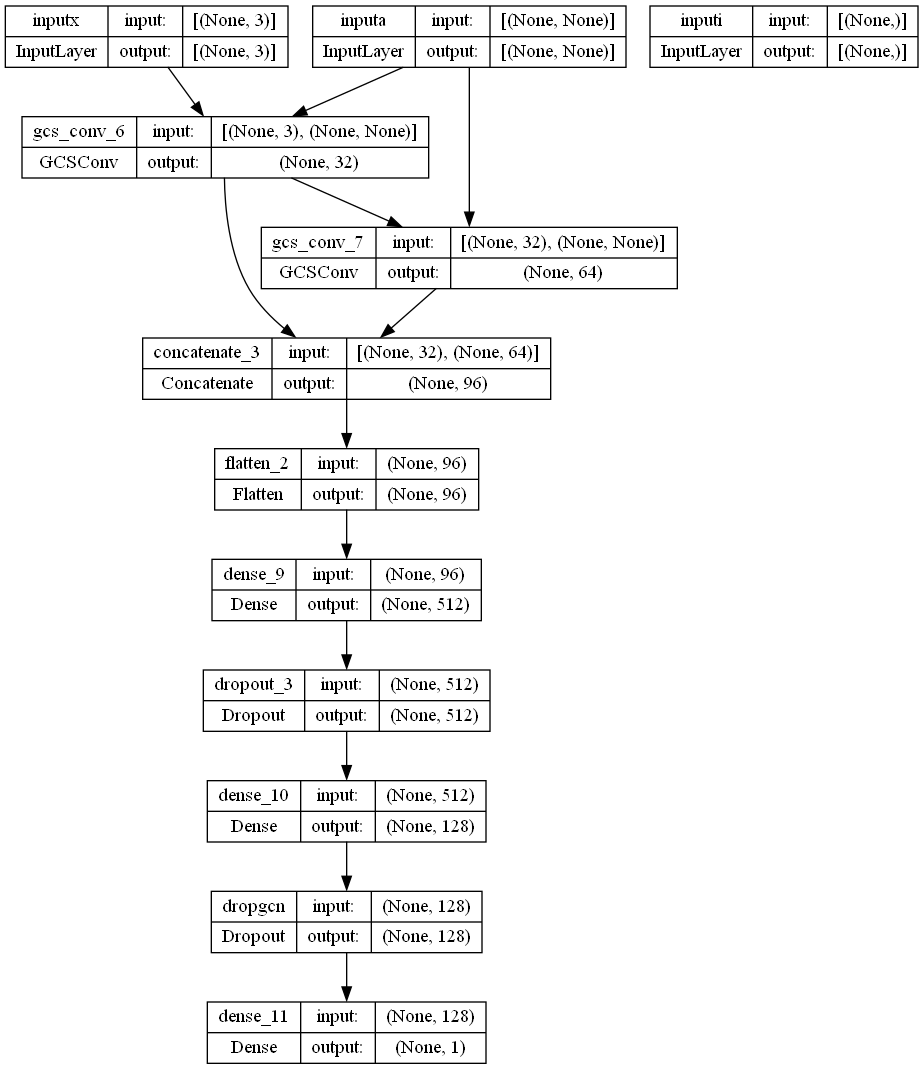

In [15]:
keras.utils.plot_model(model, "savedimages/test.png", show_shapes=True)

In [11]:
#Define overfit callbacks
def get_overfit_callbacks(patience, lr_factor):
  
  return [
      # Learning rate is reduced by 'lr_factor' if val_loss stagnates
      # for a number of epochs set with 'patience/2' var.     
      ReduceLROnPlateau(monitor="loss", mode="min",
                        factor=lr_factor, min_lr=1e-8, patience=patience//2, verbose=1)]

In [17]:
with tf.device("CPU"):
    loader = DisjointLoader(dataset, batch_size=1)
    testloader = DisjointLoader(testdataset, batch_size=1)

In [20]:
history = model.fit(loader.load(), validation_data=testloader.load(), validation_steps=testloader.steps_per_epoch, steps_per_epoch=loader.steps_per_epoch, epochs=1000, verbose=2, callbacks=get_overfit_callbacks(patience=40,lr_factor=0.3))

Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 27s - loss: 75.9502 - mape: 75.8207 - mae: 238.8871 - val_loss: 74.0751 - val_mape: 73.9639 - val_mae: 307.3659 - lr: 0.0010 - 27s/epoch - 9ms/step
Epoch 2/1000
3000/3000 - 27s - loss: 72.9353 - mape: 72.8178 - mae: 236.0504 - val_loss: 72.7796 - val_mape: 72.6658 - val_mae: 306.9602 - lr: 0.0010 - 27s/epoch - 9ms/step
Epoch 3/1000


KeyboardInterrupt: 

In [ ]:
dfcopy = features.copy()
build_times = features["build_time"]
dfcopy.drop("build_time", axis=1,inplace=True)

In [ ]:
metrics = model.evaluate(xtestt,ytestt)
print('Metrics: {}'.format(metrics))

In [6]:
#Define callbacks
def get_callbacks(weights_file, patience, lr_factor):
  
  return [
      # Only save the weights that correspond to the minimum mape.
      ModelCheckpoint(filepath= weights_file,
                      monitor="val_mape", 
                      mode="min",
                      save_best_only=True, 
                      save_weights_only=False),
      # If val_loss doesn't improve for a number of epochs set with 'patience' var 
      # training will stop to avoid overfitting.    
      EarlyStopping(monitor="val_loss",
                    mode="min",
                    patience = patience,
                    verbose=1),
      # Learning rate is reduced by 'lr_factor' if val_loss stagnates
      # for a number of epochs set with 'patience/2' var.     
      ReduceLROnPlateau(monitor="val_loss", mode="min",
                        factor=lr_factor, min_lr=1e-8, patience=patience//2, verbose=1)]

In [65]:
with tf.device("CPU"):
    loader = BatchLoader(dataset, batch_size=4) #PackedBatchLoader if memory is not an issue ;(
    testloader = BatchLoader(testdataset, batch_size=4) #batch size 8 max

In [42]:
history = model.fit(loader.load(), validation_data=testloader.load(), validation_steps=testloader.steps_per_epoch, steps_per_epoch=loader.steps_per_epoch, epochs=1000, verbose=2, callbacks=get_callbacks('savedmodels/GCNmodel_final_simplified',patience=60,lr_factor=0.3))

Epoch 1/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 137.7483 - mape: 135.2490 - mae: 253.0011 - val_loss: 75.9813 - val_mape: 73.5611 - val_mae: 292.1222 - lr: 0.0010 - 10s/epoch - 28ms/step
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 93.4430 - mape: 91.0339 - mae: 235.0443 - val_loss: 79.1428 - val_mape: 76.7442 - val_mae: 298.8966 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 3/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 86.5786 - mape: 84.1893 - mae: 234.5963 - val_loss: 72.2689 - val_mape: 69.8879 - val_mae: 298.4263 - lr: 0.0010 - 10s/epoch - 28ms/step
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 81.8460 - mape: 79.4662 - mae: 231.4707 - val_loss: 87.1289 - val_mape: 84.7572 - val_mae: 303.7747 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 5/1000
375/375 - 9s - loss: 75.5857 - mape: 73.2166 - mae: 228.2726 - val_loss: 85.4555 - val_mape: 83.0873 - val_mae: 304.9144 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 6/1000
375/375 - 9s - loss: 78.6966 - mape: 76.3323 - mae: 229.3918 - val_loss: 78.2302 - val_mape: 75.8737 - val_mae: 295.7078 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 7/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 70.3831 - mape: 68.0356 - mae: 224.8365 - val_loss: 63.3059 - val_mape: 60.9660 - val_mae: 287.9286 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 8/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 69.4144 - mape: 67.0776 - mae: 223.9903 - val_loss: 70.8669 - val_mape: 68.5308 - val_mae: 296.8812 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 9/1000
375/375 - 9s - loss: 68.4431 - mape: 66.1124 - mae: 223.4521 - val_loss: 65.6293 - val_mape: 63.2979 - val_mae: 293.5606 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 10/1000
375/375 - 8s - loss: 64.8520 - mape: 62.5231 - mae: 222.4884 - val_loss: 63.4479 - val_mape: 61.1212 - val_mae: 285.5903 - lr: 0.0010 - 8s/epoch - 23ms/step
Epoch 11/1000
375/375 - 9s - loss: 66.5124 - mape: 64.1981 - mae: 221.9621 - val_loss: 63.4099 - val_mape: 61.1088 - val_mae: 290.9541 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 12/1000
375/375 - 9s - loss: 66.0000 - mape: 63.7010 - mae: 223.2144 - val_loss: 72.8655 - val_mape: 70.5695 - val_mae: 299.6677 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 13/1000
375/375 - 9s - loss: 66.4756 - mape: 64.1853 - mae: 222.9817 - val_loss: 94.0349 - val_mape: 91.7468 - val_mae: 302.0135 - lr: 0.0010 - 9s/epoch -

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 65.1107 - mape: 62.8329 - mae: 223.5937 - val_loss: 62.1879 - val_mape: 59.9177 - val_mae: 286.4609 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 16/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 63.2160 - mape: 60.9589 - mae: 221.1878 - val_loss: 64.8053 - val_mape: 62.5559 - val_mae: 288.0037 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 17/1000
375/375 - 9s - loss: 63.1316 - mape: 60.8871 - mae: 221.3038 - val_loss: 63.3195 - val_mape: 61.0771 - val_mae: 289.8832 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 18/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 63.4954 - mape: 61.2571 - mae: 221.1621 - val_loss: 61.9016 - val_mape: 59.6675 - val_mae: 284.0745 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 19/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 63.2214 - mape: 60.9989 - mae: 221.0750 - val_loss: 62.3848 - val_mape: 60.1666 - val_mae: 289.0278 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 20/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 61.7866 - mape: 59.5767 - mae: 220.4173 - val_loss: 61.1770 - val_mape: 58.9742 - val_mae: 288.6814 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 21/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 62.3515 - mape: 60.1595 - mae: 219.8004 - val_loss: 60.8027 - val_mape: 58.6250 - val_mae: 284.2420 - lr: 0.0010 - 10s/epoch - 26ms/step
Epoch 22/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 8s - loss: 61.1885 - mape: 59.0254 - mae: 218.7997 - val_loss: 64.3929 - val_mape: 62.2437 - val_mae: 288.0216 - lr: 0.0010 - 8s/epoch - 22ms/step
Epoch 23/1000
375/375 - 9s - loss: 60.4775 - mape: 58.3464 - mae: 218.0886 - val_loss: 63.3566 - val_mape: 61.2388 - val_mae: 292.2975 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 24/1000
375/375 - 9s - loss: 60.4915 - mape: 58.3796 - mae: 219.4712 - val_loss: 62.0318 - val_mape: 59.9321 - val_mae: 287.0576 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 25/1000
375/375 - 9s - loss: 60.9936 - mape: 58.9053 - mae: 219.2080 - val_loss: 61.9121 - val_mape: 59.8234 - val_mae: 290.9830 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 26/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 59.4607 - mape: 57.3807 - mae: 217.9628 - val_loss: 59.2504 - val_mape: 57.1830 - val_mae: 281.6243 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 27/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 59.6599 - mape: 57.6135 - mae: 217.9069 - val_loss: 58.6234 - val_mape: 56.5852 - val_mae: 283.8397 - lr: 0.0010 - 10s/epoch - 26ms/step
Epoch 28/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 61.1188 - mape: 59.0896 - mae: 216.8195 - val_loss: 60.0498 - val_mape: 58.0249 - val_mae: 289.0276 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 29/1000
375/375 - 9s - loss: 59.4888 - mape: 57.4785 - mae: 217.9685 - val_loss: 58.6011 - val_mape: 56.6004 - val_mae: 282.1108 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 30/1000
375/375 - 9s - loss: 58.2031 - mape: 56.2241 - mae: 216.7360 - val_loss: 61.1469 - val_mape: 59.1897 - val_mae: 290.9167 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 31/1000
375/375 - 9s - loss: 58.2413 - mape: 56.2955 - mae: 217.4721 - val_loss: 59.1692 - val_mape: 57.2264 - val_mae: 284.2030 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 32/1000
375/375 - 9s - loss: 57.5488 - mape: 55.6187 - mae: 217.1300 - val_loss: 60.4072 - val_mape: 58.4746 - val_mae: 278.7888 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 33/1000
375/375 - 9s - loss: 58.7110 - mape: 56.7886 - mae: 216.8969 - val_loss: 58.9030 - val_mape: 56.9850 - val_mae: 285.2974 - lr: 0.0010 - 9s/epoch 

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 56.4716 - mape: 54.5564 - mae: 214.3926 - val_loss: 56.0941 - val_mape: 54.1805 - val_mae: 278.6722 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 36/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 56.6918 - mape: 54.7869 - mae: 214.1374 - val_loss: 67.5294 - val_mape: 65.6333 - val_mae: 282.1462 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 37/1000
375/375 - 9s - loss: 56.6750 - mape: 54.7894 - mae: 214.2611 - val_loss: 56.3125 - val_mape: 54.4354 - val_mae: 280.5242 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 38/1000
375/375 - 9s - loss: 55.8062 - mape: 53.9286 - mae: 214.2492 - val_loss: 57.2578 - val_mape: 55.3768 - val_mae: 279.5548 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 39/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 56.5502 - mape: 54.6711 - mae: 215.2103 - val_loss: 55.8765 - val_mape: 53.9981 - val_mae: 278.8600 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 40/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 55.6327 - mape: 53.7605 - mae: 214.2116 - val_loss: 56.9238 - val_mape: 55.0485 - val_mae: 276.0422 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 41/1000
375/375 - 9s - loss: 56.2754 - mape: 54.3978 - mae: 214.3048 - val_loss: 58.1485 - val_mape: 56.2667 - val_mae: 277.7050 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 42/1000
375/375 - 9s - loss: 54.7214 - mape: 52.8414 - mae: 212.9417 - val_loss: 57.6590 - val_mape: 55.7825 - val_mae: 276.6443 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 43/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 55.6226 - mape: 53.7377 - mae: 213.8226 - val_loss: 55.8312 - val_mape: 53.9480 - val_mae: 280.3972 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 44/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 53.8444 - mape: 51.9658 - mae: 211.8454 - val_loss: 63.8855 - val_mape: 62.0171 - val_mae: 281.4250 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 45/1000
375/375 - 9s - loss: 55.8218 - mape: 53.9444 - mae: 212.6178 - val_loss: 57.0554 - val_mape: 55.1676 - val_mae: 282.0246 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 46/1000
375/375 - 9s - loss: 54.4171 - mape: 52.5202 - mae: 212.0978 - val_loss: 57.0389 - val_mape: 55.1379 - val_mae: 280.6519 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 47/1000
375/375 - 9s - loss: 54.7052 - mape: 52.8016 - mae: 211.4864 - val_loss: 67.9869 - val_mape: 66.0801 - val_mae: 291.3620 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 48/1000
375/375 - 9s - loss: 53.6513 - mape: 51.7441 - mae: 211.0539 - val_loss: 57.8996 - val_mape: 55.9932 - val_mae: 278.2151 - lr: 0.0010 - 9s/epoch - 25ms/step
Epoch 49/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 11s - loss: 53.5022 - mape: 51.5939 - mae: 210.5254 - val_loss: 54.7010 - val_mape: 52.7962 - val_mae: 276.4564 - lr: 0.0010 - 11s/epoch - 28ms/step
Epoch 50/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 53.3040 - mape: 51.3927 - mae: 210.5198 - val_loss: 54.5504 - val_mape: 52.6373 - val_mae: 278.1083 - lr: 0.0010 - 10s/epoch - 26ms/step
Epoch 51/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 52.3899 - mape: 50.4781 - mae: 209.7956 - val_loss: 60.2280 - val_mape: 58.3232 - val_mae: 285.4435 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 52/1000
375/375 - 9s - loss: 53.1967 - mape: 51.2900 - mae: 210.3746 - val_loss: 55.7777 - val_mape: 53.8658 - val_mae: 279.1886 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 53/1000
375/375 - 9s - loss: 52.1138 - mape: 50.1955 - mae: 209.9934 - val_loss: 56.4273 - val_mape: 54.5064 - val_mae: 279.7371 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 54/1000
375/375 - 9s - loss: 52.1154 - mape: 50.1860 - mae: 209.7946 - val_loss: 55.0872 - val_mape: 53.1601 - val_mae: 276.0153 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 55/1000
375/375 - 9s - loss: 52.0083 - mape: 50.0845 - mae: 208.8002 - val_loss: 57.9890 - val_mape: 56.0608 - val_mae: 279.0504 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 56/1000
375/375 - 9s - loss: 52.1309 - mape: 50.1973 - mae: 208.8430 - val_loss: 55.1259 - val_mape: 53.1993 - val_mae: 273.8879 - lr: 0.0010 - 9s/epoch 

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 51.2367 - mape: 49.3039 - mae: 208.1203 - val_loss: 54.4440 - val_mape: 52.5067 - val_mae: 277.2282 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 58/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 51.8345 - mape: 49.8932 - mae: 208.2665 - val_loss: 54.8969 - val_mape: 52.9524 - val_mae: 277.9506 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 59/1000
375/375 - 9s - loss: 52.6299 - mape: 50.6806 - mae: 208.5224 - val_loss: 54.9571 - val_mape: 53.0098 - val_mae: 265.3625 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 60/1000
375/375 - 9s - loss: 51.3637 - mape: 49.4134 - mae: 207.5920 - val_loss: 57.0138 - val_mape: 55.0612 - val_mae: 281.0519 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 61/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 50.4770 - mape: 48.5190 - mae: 207.0472 - val_loss: 54.1405 - val_mape: 52.1806 - val_mae: 274.1278 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 62/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 51.0205 - mape: 49.0480 - mae: 208.4300 - val_loss: 55.0979 - val_mape: 53.1304 - val_mae: 272.3793 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 63/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 11s - loss: 51.8459 - mape: 49.8632 - mae: 208.7182 - val_loss: 53.4994 - val_mape: 51.5037 - val_mae: 274.0134 - lr: 0.0010 - 11s/epoch - 28ms/step
Epoch 64/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 50.9838 - mape: 48.9813 - mae: 207.3802 - val_loss: 55.4725 - val_mape: 53.4682 - val_mae: 273.5450 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 65/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 51.2902 - mape: 49.2672 - mae: 207.4164 - val_loss: 52.7409 - val_mape: 50.7139 - val_mae: 270.1325 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 66/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 50.0735 - mape: 48.0417 - mae: 205.8620 - val_loss: 53.0329 - val_mape: 50.9983 - val_mae: 271.0805 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 67/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 51.2004 - mape: 49.1636 - mae: 206.5947 - val_loss: 51.4169 - val_mape: 49.3708 - val_mae: 271.5211 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 68/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 50.2831 - mape: 48.2416 - mae: 206.3985 - val_loss: 51.6216 - val_mape: 49.5696 - val_mae: 264.2295 - lr: 0.0010 - 9s/epoch - 25ms/step
Epoch 69/1000
375/375 - 9s - loss: 49.4850 - mape: 47.4302 - mae: 204.8212 - val_loss: 53.1525 - val_mape: 51.0896 - val_mae: 267.3344 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 70/1000
375/375 - 9s - loss: 48.7911 - mape: 46.7268 - mae: 203.6994 - val_loss: 52.7713 - val_mape: 50.7020 - val_mae: 269.7104 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 71/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 49.6394 - mape: 47.5666 - mae: 204.6916 - val_loss: 51.2067 - val_mape: 49.1332 - val_mae: 265.2686 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 72/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 50.0294 - mape: 47.9457 - mae: 205.4274 - val_loss: 52.3447 - val_mape: 50.2522 - val_mae: 274.3723 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 73/1000
375/375 - 9s - loss: 49.5645 - mape: 47.4608 - mae: 204.4158 - val_loss: 51.6663 - val_mape: 49.5589 - val_mae: 263.7450 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 74/1000
375/375 - 9s - loss: 48.3324 - mape: 46.2238 - mae: 202.7732 - val_loss: 57.2213 - val_mape: 55.1042 - val_mae: 278.3050 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 75/1000
375/375 - 8s - loss: 48.5047 - mape: 46.3817 - mae: 202.8735 - val_loss: 52.7709 - val_mape: 50.6460 - val_mae: 274.4421 - lr: 0.0010 - 8s/epoch - 23ms/step
Epoch 76/1000
375/375 - 9s - loss: 48.1659 - mape: 46.0338 - mae: 202.7593 - val_loss: 51.6829 - val_mape: 49.5475 - val_mae: 262.9035 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 77/1000
375/375 - 9s - loss: 48.0335 - mape: 45.8878 - mae: 202.6435 - val_loss: 53.2761 - val_mape: 51.1263 - val_mae: 268.5591 - lr: 0.0010 - 9s/epoch 

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 47.6186 - mape: 45.3717 - mae: 202.2724 - val_loss: 50.3011 - val_mape: 48.0469 - val_mae: 263.5177 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 84/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 47.8445 - mape: 45.5755 - mae: 201.0207 - val_loss: 50.6671 - val_mape: 48.3935 - val_mae: 265.2473 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 85/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 47.4372 - mape: 45.1646 - mae: 201.5094 - val_loss: 50.0609 - val_mape: 47.7836 - val_mae: 263.4994 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 86/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 46.6284 - mape: 44.3491 - mae: 200.5794 - val_loss: 48.8874 - val_mape: 46.6052 - val_mae: 265.2354 - lr: 0.0010 - 10s/epoch - 26ms/step
Epoch 87/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 47.3880 - mape: 45.1002 - mae: 200.6664 - val_loss: 53.3628 - val_mape: 51.0637 - val_mae: 274.3526 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 88/1000
375/375 - 9s - loss: 47.6731 - mape: 45.3606 - mae: 200.0600 - val_loss: 53.4044 - val_mape: 51.0829 - val_mae: 272.6363 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 89/1000
375/375 - 9s - loss: 47.3151 - mape: 44.9826 - mae: 199.3952 - val_loss: 50.4494 - val_mape: 48.1125 - val_mae: 264.6324 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 90/1000
375/375 - 9s - loss: 46.1295 - mape: 43.7877 - mae: 198.6027 - val_loss: 49.1884 - val_mape: 46.8500 - val_mae: 258.9509 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 91/1000
375/375 - 9s - loss: 46.5582 - mape: 44.2164 - mae: 200.5677 - val_loss: 49.4338 - val_mape: 47.0865 - val_mae: 265.6613 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 92/1000
375/375 - 9s - loss: 45.6851 - mape: 43.3257 - mae: 198.9464 - val_loss: 51.1625 - val_mape: 48.7999 - val_mae: 259.5064 - lr: 0.0010 - 9s/epoch 

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 45.4207 - mape: 43.0415 - mae: 198.3284 - val_loss: 47.9338 - val_mape: 45.5540 - val_mae: 260.5036 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 95/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 46.6160 - mape: 44.2338 - mae: 197.9574 - val_loss: 52.2851 - val_mape: 49.8966 - val_mae: 261.7867 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 96/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 45.5533 - mape: 43.1577 - mae: 197.8511 - val_loss: 47.4525 - val_mape: 45.0437 - val_mae: 256.7925 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 97/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 46.7776 - mape: 44.3589 - mae: 198.6625 - val_loss: 48.0177 - val_mape: 45.5922 - val_mae: 262.1666 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 98/1000
375/375 - 9s - loss: 45.1184 - mape: 42.6853 - mae: 198.0109 - val_loss: 51.2777 - val_mape: 48.8351 - val_mae: 257.5191 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 99/1000
375/375 - 9s - loss: 45.4337 - mape: 42.9889 - mae: 197.6406 - val_loss: 49.1887 - val_mape: 46.7392 - val_mae: 256.6775 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 100/1000
375/375 - 9s - loss: 45.6291 - mape: 43.1787 - mae: 198.8778 - val_loss: 47.4981 - val_mape: 45.0441 - val_mae: 259.2243 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 101/1000
375/375 - 9s - loss: 44.8110 - mape: 42.3534 - mae: 196.8624 - val_loss: 53.4490 - val_mape: 50.9895 - val_mae: 267.5748 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 102/1000
375/375 - 9s - loss: 45.4982 - mape: 43.0365 - mae: 197.6198 - val_loss: 47.8721 - val_mape: 45.4056 - val_mae: 253.3179 - lr: 0.0010 - 9s/epo

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 45.3442 - mape: 42.8172 - mae: 197.6465 - val_loss: 47.5268 - val_mape: 44.9975 - val_mae: 262.0384 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 107/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 44.5595 - mape: 42.0275 - mae: 196.4500 - val_loss: 50.1427 - val_mape: 47.6067 - val_mae: 264.7622 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 108/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 44.7031 - mape: 42.1622 - mae: 196.8116 - val_loss: 47.4473 - val_mape: 44.9062 - val_mae: 256.4054 - lr: 0.0010 - 10s/epoch - 28ms/step
Epoch 109/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 44.7579 - mape: 42.2094 - mae: 196.0708 - val_loss: 48.5333 - val_mape: 45.9812 - val_mae: 263.1225 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 110/1000
375/375 - 9s - loss: 44.4025 - mape: 41.8483 - mae: 195.4833 - val_loss: 48.3767 - val_mape: 45.8188 - val_mae: 259.5448 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 111/1000
375/375 - 9s - loss: 43.7907 - mape: 41.2299 - mae: 194.7764 - val_loss: 48.8178 - val_mape: 46.2599 - val_mae: 261.9345 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 112/1000


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 43.2285 - mape: 40.6618 - mae: 195.2236 - val_loss: 46.2448 - val_mape: 43.6735 - val_mae: 256.4854 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 113/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 43.7259 - mape: 41.1496 - mae: 194.4836 - val_loss: 48.9403 - val_mape: 46.3565 - val_mae: 261.6952 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 114/1000
375/375 - 9s - loss: 43.5612 - mape: 40.9748 - mae: 194.9505 - val_loss: 46.9397 - val_mape: 44.3491 - val_mae: 258.9303 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 115/1000
375/375 - 9s - loss: 43.7453 - mape: 41.1498 - mae: 194.8033 - val_loss: 49.9963 - val_mape: 47.3966 - val_mae: 255.6403 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 116/1000
375/375 - 9s - loss: 45.0654 - mape: 42.4602 - mae: 196.2312 - val_loss: 47.6284 - val_mape: 45.0158 - val_mae: 250.5571 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 117/1000
375/375 - 9s - loss: 43.6178 - mape: 41.0052 - mae: 194.1169 - val_loss: 48.2472 - val_mape: 45.6403 - val_mae: 261.4172 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 118/1000
375/375 - 9s - loss: 43.7062 - mape: 41.0949 - mae: 194.3498 - val_loss: 48.5880 - val_mape: 45.9733 - val_mae: 260.0522 - lr: 0.0010 - 9s/e

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 43.4571 - mape: 40.7274 - mae: 194.1849 - val_loss: 45.8476 - val_mape: 43.1091 - val_mae: 249.4701 - lr: 0.0010 - 10s/epoch - 27ms/step
Epoch 127/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


INFO:tensorflow:Assets written to: savedmodels\GCNmodel_final_simplified\assets


375/375 - 10s - loss: 42.9093 - mape: 40.1686 - mae: 193.6229 - val_loss: 45.4749 - val_mape: 42.7319 - val_mae: 253.9619 - lr: 0.0010 - 10s/epoch - 26ms/step
Epoch 128/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.con

375/375 - 9s - loss: 42.0553 - mape: 39.3080 - mae: 192.5627 - val_loss: 47.6770 - val_mape: 44.9327 - val_mae: 256.8749 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 129/1000
375/375 - 9s - loss: 42.0418 - mape: 39.2940 - mae: 192.7486 - val_loss: 52.2410 - val_mape: 49.4857 - val_mae: 265.0598 - lr: 0.0010 - 9s/epoch - 25ms/step
Epoch 130/1000
375/375 - 9s - loss: 42.9469 - mape: 40.1785 - mae: 192.6641 - val_loss: 47.5403 - val_mape: 44.7653 - val_mae: 251.6560 - lr: 0.0010 - 9s/epoch - 23ms/step
Epoch 131/1000
375/375 - 9s - loss: 43.5927 - mape: 40.8139 - mae: 193.8075 - val_loss: 46.5536 - val_mape: 43.7642 - val_mae: 252.6366 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 132/1000
375/375 - 9s - loss: 43.0945 - mape: 40.3034 - mae: 193.2945 - val_loss: 52.6841 - val_mape: 49.8800 - val_mae: 267.0756 - lr: 0.0010 - 9s/epoch - 24ms/step
Epoch 133/1000
375/375 - 9s - loss: 43.2070 - mape: 40.3943 - mae: 195.3468 - val_loss: 48.6936 - val_mape: 45.8743 - val_mae: 263.7007 - lr: 0.0010 - 9s/e

<function matplotlib.pyplot.show(close=None, block=None)>

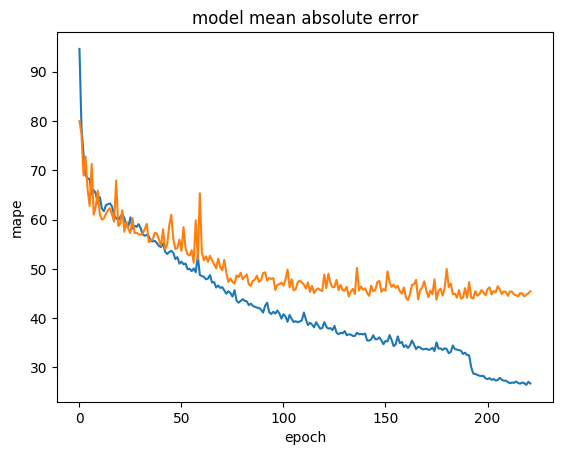

In [36]:
#Plot mape
plt.plot(history.history["mape"])
plt.plot(history.history["val_mape"])
plt.title('model mean absolute error')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.show

In [23]:
with open('savedmodels/histories/GCN_final.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [23]:
with open('savedmodels/histories/GCN_disjoint_3000.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [60]:
#Multiple layer overfit tuner

#Remove old search
try:
    shutil.rmtree("multiple_layers_tuning_gcn")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


def model_builder(hp):
  xi = Input(shape=(None,3), name= "inputx")
  ai = Input(shape=(None,None), name= 'inputa')

  x = GCSConv(hp.Int(f"nodes_0", min_value=8, max_value=256, step=8))([xi,ai])
  layers = []
  layers.append(x)
  hp_convlayers = hp.Int("convlayers", min_value=1, max_value=8, step=1)
  for i in range(hp_convlayers):
    x = GCSConv(hp.Int(f"nodes_{i + 1}", min_value=8, max_value=256, step=8))([x,ai])
    layers.append(x)


  x = Concatenate()(layers)
  x = GlobalMaxPool()(x)
  hp_denselayers = hp.Int("denselayers", min_value=1, max_value=8, step=1)
  for i in range(hp_denselayers):
    x = Dense(hp.Int(f"dense_{i}", min_value=8, max_value=512, step=8))(x)


  x = Dropout(0.2)(x)
  x = Dense(1, 'linear')(x)
  model = Model(inputs=[xi,ai], outputs=x)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mape', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), 'mae'])
  return model


tuner = kt.Hyperband(
    model_builder,
    max_epochs=200,
    factor=3,
    objective = 'loss',
    project_name = "multiple_layers_tuning_gcn"
)
'''tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'loss',
    max_trials = 50,
    executions_per_trial = 1,
    project_name = "multiple_layers_tuning_gcn"
)'''

tuner.search_space_summary()

Search space summary
Default search space size: 5
nodes_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
convlayers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': None}
nodes_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
denselayers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': None}
dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 8, 'sampling': None}


In [61]:
#Search overfit
tuner.search(loader.load(), steps_per_epoch=loader.steps_per_epoch, epochs=50, callbacks=get_overfit_callbacks(
                                                                                                    patience=80,
                                                                                                    lr_factor=0.2))

Trial 112 Complete [00h 00m 06s]
loss: 37.64982223510742

Best loss So Far: 34.27772903442383
Total elapsed time: 00h 09m 14s

Search: Running Trial #113

Value             |Best Value So Far |Hyperparameter
248               |112               |nodes_0
3                 |1                 |convlayers
176               |176               |nodes_1
7                 |3                 |denselayers
136               |72                |dense_0
248               |16                |nodes_2
384               |168               |dense_1
80                |280               |dense_2
88                |344               |dense_3
8                 |184               |nodes_3
128               |232               |nodes_4
24                |184               |nodes_5
320               |264               |dense_4
80                |304               |dense_5
192               |360               |dense_6
32                |16                |nodes_6
40                |160               |nodes_7
64 

KeyboardInterrupt: 

In [9]:
#Multiple layer tuner

#Remove old search
try:
    shutil.rmtree("multiple_layers_tuning_gcn")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


def model_builder(hp):
  xi = Input(shape=(None,3), name= "inputx")
  ai = Input(shape=(None,None), name= 'inputa')
  x1 = GCSConv(64)([xi,ai])
  x2 = GCSConv(64)([x1,ai])
  x3 = GCSConv(64)([x2,ai])
  x4 = GCSConv(128)([x3,ai])

  x = Concatenate()([x1,x2,x3,x4])
  x = GlobalMaxPool()(x)

  hp_denselayers = hp.Int("denselayers", min_value=1, max_value=5, step=1)
  for i in range(hp_denselayers):
     x = Dense(hp.Int(f"nodes_{i}", min_value=256, max_value=512, step=16))(x)

  x = Dropout(0.5)(x)
  x = Dense(1, 'linear')(x)
  model = Model(inputs=[xi,ai], outputs=x)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mape', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), 'mae'])
  return model

'''tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_mape',
    max_trials = 10,
    executions_per_trial = 3,
    project_name = "multiple_layers_tuning_gcn"
)'''

tuner = kt.Hyperband(
    model_builder,
    max_epochs=100,
    factor=3,
    objective = 'val_mape',
    project_name = "multiple_layers_tuning_gcn"
)

tuner.search_space_summary()

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Search space summary
Default search space size: 2
denselayers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
nodes_0 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 16, 'sampling': None}


In [10]:
#Search
tuner.search(loader.load(), validation_data=testloader.load(), validation_steps=testloader.steps_per_epoch, steps_per_epoch=loader.steps_per_epoch, epochs=100, callbacks=get_callbacks('savedmodels/tunergcn',
                                                                                                    patience=30,
                                                                                                    lr_factor=0.2))

Trial 115 Complete [00h 00m 52s]
val_mape: 286.68597412109375

Best val_mape So Far: 41.72275924682617
Total elapsed time: 01h 42m 18s

Search: Running Trial #116

Value             |Best Value So Far |Hyperparameter
1                 |5                 |denselayers
432               |432               |nodes_0
480               |384               |nodes_1
432               |368               |nodes_2
400               |304               |nodes_3
4                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0003              |None              |tuner/trial_id



c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 3/4
23/23 [==============================] - ETA: 0s - loss: 654.5415 - mape: 654.5415 - mae: 422.1732

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


INFO:tensorflow:Assets written to: savedmodels\tunergcn\assets


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


23/23 [==============================] - 27s 1s/step - loss: 654.5415 - mape: 654.5415 - mae: 422.1732 - val_loss: 483.9268 - val_mape: 483.9268 - val_mae: 96.2022 - lr: 0.0010
Epoch 4/4
22/23 [===========================>..] - ETA: 0s - loss: 563.8765 - mape: 563.8765 - mae: 397.1982

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


KeyboardInterrupt: 

In [62]:
#Results
tuner.results_summary(1)

Results summary
Results in .\multiple_layers_tuning_gcn
Showing 1 best trials
Trial summary
Hyperparameters:
nodes_0: 112
convlayers: 1
nodes_1: 176
denselayers: 3
dense_0: 72
nodes_2: 16
dense_1: 168
dense_2: 280
dense_3: 344
nodes_3: 184
nodes_4: 232
nodes_5: 184
dense_4: 264
dense_5: 304
dense_6: 360
nodes_6: 16
nodes_7: 160
nodes_8: 168
dense_7: 232
tuner/epochs: 8
tuner/initial_epoch: 3
tuner/bracket: 4
tuner/round: 1
tuner/trial_id: 0093
Score: 34.27772903442383


In [ ]:
history.history

<function matplotlib.pyplot.show(close=None, block=None)>

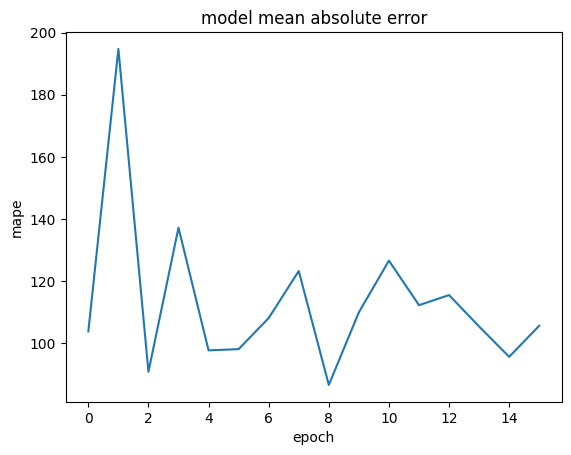

In [ ]:
#Plot mape
plt.plot(history.history["mape"])
plt.title('model mean absolute error')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.show